In [1]:
import os, sys
print("Working dir:"+os.getcwd())
print("Python version:"+sys.version)

Working dir:/Users/kin/Library/Mobile Documents/com~apple~CloudDocs/Year 4/AI/Coursework
Python version:3.9.18 (main, Jan 16 2024, 15:38:36) 
[Clang 14.0.0 (clang-1400.0.29.202)]


In [7]:
from copy import deepcopy
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import lines

In [9]:
import networkx as nx
print("networkx version: "+nx.__version__)

networkx version: 3.2.1


In [10]:
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
print("ipywidgets version: " + widgets.__version__)

ipywidgets version: 8.1.5


In [11]:
AIMA_TOOLBOX_ROOT="/Users/kin/Library/Mobile Documents/com~apple~CloudDocs/Year 4/AI/Lab/lab_week2 /aima-python-uofg_v20212022a"
sys.path.append(AIMA_TOOLBOX_ROOT)

In [12]:
from search import *
from notebookutils import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens
# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

In [110]:
import random
from mazelib import Maze
from mazelib.generate.Prims import Prims

N = 20
m = Maze()
m.generator = Prims(int(N / 2), int(N / 2))
m.generate()
m.generate_entrances(True, True)

start_row, start_col = m.start
goal_row, goal_col = m.end

m.grid[start_row][start_col] = 0
m.grid[goal_row][goal_col] = 0

print(m)
print("Start coordinates:", m.start)
print("Value at start location:", m.grid[start_row][start_col])
print("Goal coordinates:", m.end)
print("Value at goal location:", m.grid[goal_row][goal_col])

#################E###
#   # #   #   # # # #
# ### ### # ### # # #
# # # # #   #       #
# # # # # ### ### ###
#   #           # # #
# # # ############# #
# # # # #   # #   # #
# ### # # ### # ### #
# # # #         #   #
# # # ### # ### # # #
# # #     # # #   # #
# # # ### ### ### ###
#       # #     #   #
# # # ### # ##### ###
# # # # # #   #     #
# ##### ### #########
#               #   #
# ### # # # # # # ###
#   # # # # # #     #
###S#################
Start coordinates: (20, 3)
Value at start location: 0
Goal coordinates: (0, 17)
Value at goal location: 0


In [115]:
teleport_links = []
num_teleports = 3

rows, cols = len(m.grid), len(m.grid[0])

for _ in range(num_teleports):
    valid_link = False
    while not valid_link:
        x1, y1 = random.choice(range(rows)), random.choice(range(cols))
        x2, y2 = random.choice(range(rows)), random.choice(range(cols))

        if m.grid[x1][y1] == 0 and m.grid[x2][y2] == 0 and (x1, y1) != (x2, y2):
            teleport_links.append(((x1, y1), (x2, y2)))
            valid_link = True

print("Teleportation Links:", teleport_links)

Teleportation Links: [((19, 11), (11, 11)), ((13, 7), (3, 13)), ((14, 9), (6, 5))]


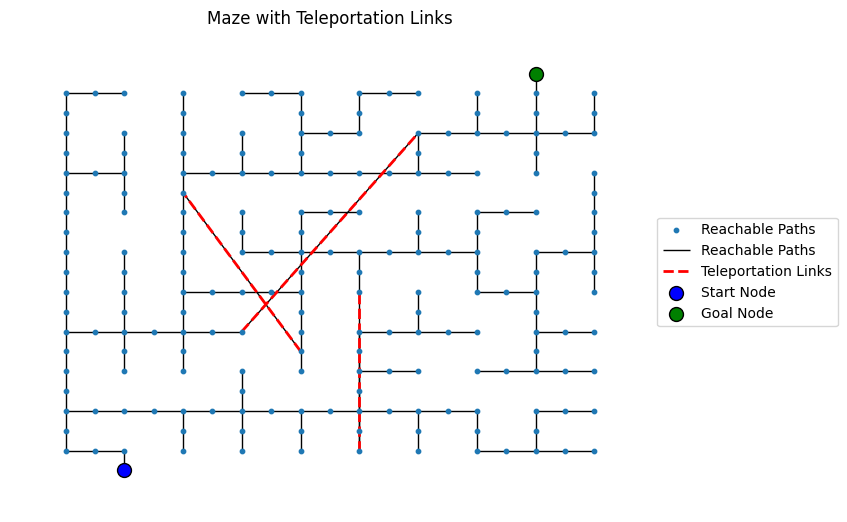

In [116]:
def visualise_maze_with_teleports(maze, teleport_links):
    rows, cols = len(maze.grid), len(maze.grid[0])
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            if maze.grid[r][c] == 0:
                G.add_node((r, c))

    for r in range(rows):
        for c in range(cols):
            if maze.grid[r][c] == 0:
                if r > 0 and maze.grid[r - 1][c] == 0:
                    G.add_edge((r, c), (r - 1, c))
                if c > 0 and maze.grid[r][c - 1] == 0:
                    G.add_edge((r, c), (r, c - 1))

    for (src, dest) in teleport_links:
        G.add_edge(src, dest, color='red', style='dashed')

    pos = {(r, c): (c, -r) for r, c in G.nodes()}
    nx.draw(G, pos, with_labels=False, node_size=10, edge_color='black', label='Reachable Paths')

    teleport_edges = [(src, dest) for (src, dest) in teleport_links]
    nx.draw_networkx_edges(G, pos, edgelist=teleport_edges, edge_color='red', style='dashed', width=2, label='Teleportation Links')

    start_node = m.start
    goal_node = m.end
    if start_node in G.nodes():
        nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='blue', label='Start Node', node_size=100, edgecolors='black')
    if goal_node in G.nodes():
        nx.draw_networkx_nodes(G, pos, nodelist=[goal_node], node_color='green', label='Goal Node', node_size=100, edgecolors='black')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Maze with Teleportation Links")
    plt.show()

visualise_maze_with_teleports(m, teleport_links)

In [108]:
import heapq

def astar_search(maze, start, goal, teleport_links):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: manhattan_distance(start, goal)}

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            return reconstruct_path(came_from, current)

        for neighbor in get_neighbors(maze, current, teleport_links):
            tentative_g_score = g_score[current] + 1
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + manhattan_distance(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(maze, current, teleport_links):
    neighbors = []
    rows, cols = len(maze.grid), len(maze.grid[0])
    r, c = current

    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dr, dc in directions:
        nr, nc = r + dr, c + dc
        if 0 <= nr < rows and 0 <= nc < cols and maze.grid[nr][nc] == 0:
            neighbors.append((nr, nc))

    for (src, dest) in teleport_links:
        if src == current:
            neighbors.append(dest)
    return neighbors

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

path = astar_search(m, m.start, m.end, teleport_links)
print("Path found by A* search:", path)


Path found by A* search: [(0, 1), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 4), (3, 5), (4, 5), (5, 5), (5, 6), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 15), (11, 15), (11, 16), (11, 17), (12, 17), (13, 17), (14, 17), (15, 17), (16, 17), (17, 17), (18, 17), (19, 17), (19, 16), (19, 15), (20, 15)]


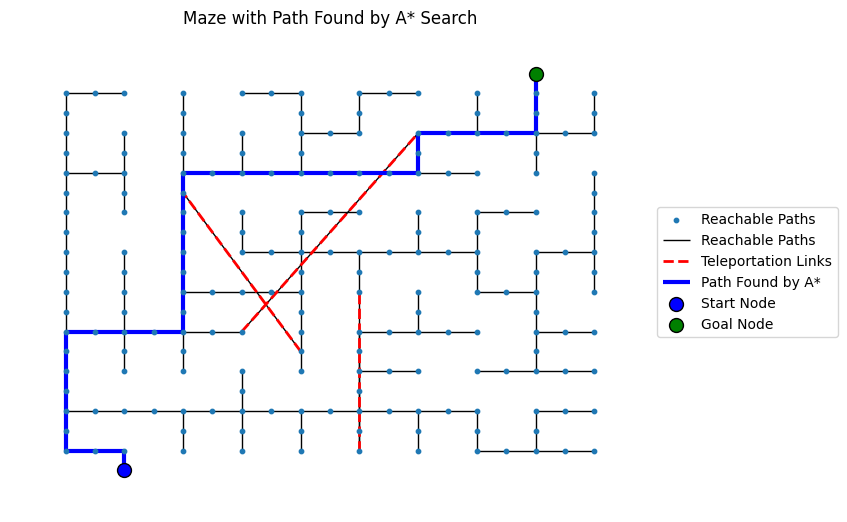

In [117]:
import matplotlib.pyplot as plt
import networkx as nx

def visualise_maze_with_path(maze, teleport_links, path):
    rows, cols = len(maze.grid), len(maze.grid[0])
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            if maze.grid[r][c] == 0:
                G.add_node((r, c))

    for r in range(rows):
        for c in range(cols):
            if maze.grid[r][c] == 0:
                if r > 0 and maze.grid[r - 1][c] == 0:
                    G.add_edge((r, c), (r - 1, c))
                if c > 0 and maze.grid[r][c - 1] == 0:
                    G.add_edge((r, c), (r, c - 1))

    for (src, dest) in teleport_links:
        G.add_edge(src, dest, color='red', style='dashed')

    pos = {(r, c): (c, -r) for r, c in G.nodes()}
    nx.draw(G, pos, with_labels=False, node_size=10, edge_color='black', label='Reachable Paths')

    teleport_edges = [(src, dest) for (src, dest) in teleport_links]
    nx.draw_networkx_edges(G, pos, edgelist=teleport_edges, edge_color='red', style='dashed', width=2, label='Teleportation Links')

    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='blue', width=3, label='Path Found by A*')

    start_node = maze.start
    goal_node = maze.end
    if start_node in G.nodes():
        nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='blue', label='Start Node', node_size=100, edgecolors='black')
    if goal_node in G.nodes():
        nx.draw_networkx_nodes(G, pos, nodelist=[goal_node], node_color='green', label='Goal Node', node_size=100, edgecolors='black')

    plt.title("Maze with Path Found by A* Search")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

path = astar_search(m, m.start, m.end, teleport_links)
visualise_maze_with_path(m, teleport_links, path)

Fixed Maze Grid:
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]
[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Start coordinates: (1, 1)
Goal coordinates: (5, 9)
Teleport Links: [((1, 5), (5, 1)), ((3, 7), (1, 8)), ((1, 2), (4, 7))]


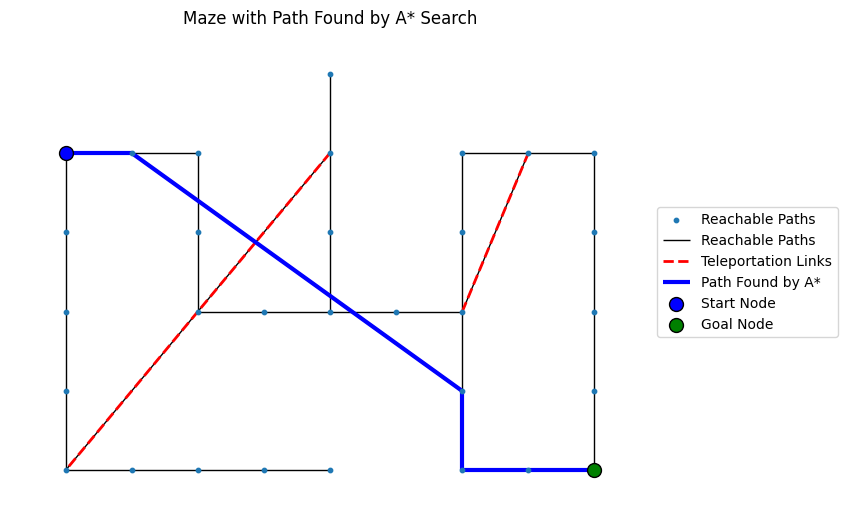

In [101]:
# # sample maze for checking if the A* algorithms actually using the teleport links.
#
# import matplotlib.pyplot as plt
# import networkx as nx
#
# class FixedMaze:
#     def __init__(self):
#         self.grid = [
#             [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
#             [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
#             [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
#             [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
#             [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
#             [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
#             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
#         ]
#         self.start = (1, 1)
#         self.end = (5, 9)
#
# def get_fixed_teleport_links():
#     teleport_links = [
#         ((1, 5), (5, 1)),
#         ((3, 7), (1, 8)),
#         ((1, 2), (4, 7)),
#     ]
#     return teleport_links
#
# m = FixedMaze()
#
# teleport_links = get_fixed_teleport_links()
#
# print("Fixed Maze Grid:")
# for row in m.grid:
#     print(row)
# print("\nStart coordinates:", m.start)
# print("Goal coordinates:", m.end)
# print("Teleport Links:", teleport_links)
#
# path = astar_search(m, m.start, m.end, teleport_links)
#
#
# visualise_maze_with_path(m, teleport_links, path)